# **Trustworthy Machine Learning**

---
**Winter Semester 2024-2025**

**Lecturer**: Seong Joon Oh

**Tutor**: Ankit Sonthalia

---

**Exercise 2 -- XAI**

---
Group number: ***Spica***

Student names: ***Sayak Mallick, Lalitha Sivakumar, Shubham Bhalchandra Kashyapi***

Student emails: ***mallicksayak@gmail.com, lalitha.sivakumar@student.uni-tuebingen.de, shubham.kashyapi@gmail.com***

---
**The deadline for this homework is on 11/12/2024 at 23:59.**

This is a **group exercise**. After we grade your submissions, all members of any given group will receive the same grade. Please report cases where any team member contributes significantly less than the other members of the same group. Like the first exercise, the grade from this exercise will count towards the final grade.

---
### Structure
This homework covers 2 broad topics. It makes sense to start working on each topic after attending the corresponding lecture. The recommendeded starting dates are indicated in the section headers, but feel free to explore by yourself too.

**How to find the parts that you need to edit?**

1. Parts where you need to write code are marked as
   ```
   #### >>>> PUT YOUR SOLUTION HERE <<<<
   #### >>>> END OF YOUR SOLUTION <<<<
   ```
2. Parts where you need to answer questions are marked as
   ```TODO your answer:```.

**Do not use any other external libraries than the ones already defined in the notebook. If you're unsure, consult the TML lecture staff first about usage.**

If you have any questions about the homework, feel free to drop us a message on Discord or come to the tutorials on Thursdays at 14:00. The lead tutor for this homework is [Ankit](https://scalabletrustworthyai.github.io/member/ankit/).

#### **How to use GPUs on Kaggle**
- Verify your phone number.
- Select your preferred GPU at `Settings > Accelerator`.
- Put parameters and tensors on CUDA via `tensor.to(device)` etc.
- Double check if the parameters and tensors are on CUDA via `tensor.device` etc.

#### Note on Kaggle

We provide our exercise notebooks on Kaggle because of Kaggle's generous free GPU policy. After phone number verification, one receives 30 hours of free GPU usage per week. This translates to 90 hours per week for a group of three. We find this to be much better than Google Colab, where one does not even know how much compute they are left with. However, if you do not wish to use Kaggle for some reason, please feel free to use any other platform that is available to you -- ultimately, you only need to submit the final notebook to us. There are no specific Kaggle dependencies in this exercise; however, in the rare event that you run into some minor python package issues, please reach out to the TML staff for help.


#### **Submission**

(1) Click on `File > Download notebook`;

(2) Send the `.ipynb` file to `stai.there@gmail.com` before the deadline.

## 1 Explaining predictions with feature attribution

In this section, you will evaluate and compare popular feature attribution (FA) methods on vision models. 

We will start by setting up the pre-requisites.

1. A LeNet model pre-trained on Fashion-MNIST  (~90% test set accuracy).
2. The Fashion-MNIST dataset.

We will also perform some sanity checks along the way.

**Plan**

**1.1** You will implement a remove-and-classify approach for evaluating FA methods. We provide a dummy feature attribution explanation (a centered Gaussian). Please use this to test your remove-and-classify function.

**1.2** You will test two feature attribution methods using the remove-and-classify function you designed above. 

**1.3** Discussion: you will answer some questions.

**Recommended start**: 14.11.2024


## 1.0 Prerequisites

In [1]:
# Set the seed for reproducibility
import os, sys
import torch
torch.manual_seed(2024)

# Make sure you are using cuda
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device in use: {device}")

Device in use: cuda


In [2]:
# Install utilities

!pip install git+https://github.com/aktsonthalia/tml2425_xai
!git clone https://huggingface.co/aktsonthalia2/tml2425_xai_models

  Cloning https://github.com/aktsonthalia/tml2425_xai to /tmp/pip-req-build-exojov2h
  Running command git clone --filter=blob:none --quiet https://github.com/aktsonthalia/tml2425_xai /tmp/pip-req-build-exojov2h
  Resolved https://github.com/aktsonthalia/tml2425_xai to commit 7eda89a7e042e8ec7539584d2e753e42b5f7afef
  Preparing metadata (setup.py) ... done
  Created wheel for tml2425_xai: filename=tml2425_xai-0.1-py3-none-any.whl size=7284 sha256=a09f055a2e7ec1e95217931c438c933b415c423bf1836ca369b824aee0374ea8
  Stored in directory: /tmp/pip-ephem-wheel-cache-fizfp8vi/wheels/8c/8b/53/c9ec6e040c45b0c794b81e536f86261f1d0399515035af9c97
Successfully built tml2425_xai
Cloning into 'tml2425_xai_models'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (8/8), 2.48 KiB | 1.24 MiB/s, done.


In [3]:
# Load the pre-trained model

from tml2425_xai.lenet import LeNet
lenet = torch.load(f"tml2425_xai_models/lenet_fashionmnist.pckl", map_location=device)
lenet.eval()

/tmp/ipykernel_30/399408301.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet = torch.load(f"tml2425_xai_models/lenet_fashionmnist.pckl", map_location=device)


LeNet(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (linear1): Linear(in_features=6272, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)

In [4]:
# Load the dataset.
# Since the model is already trained, we only require the test set.

from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.squeeze())
])

fmnist_test = datasets.FashionMNIST(
    root='./data_FashionMNIST',
    train=False,
    download=True,
    transform=transform
)

# Sanity checks
assert len(fmnist_test) == 10000
x, y = fmnist_test[0]
assert x.shape == (28, 28)
assert isinstance(y, int)

100%|██████████| 26421880/26421880 [00:03<00:00, 7175819.01it/s] 


Extracting ./data_FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 113119.98it/s]


Extracting ./data_FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2082824.55it/s]


Extracting ./data_FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10476602.13it/s]

Extracting ./data_FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw



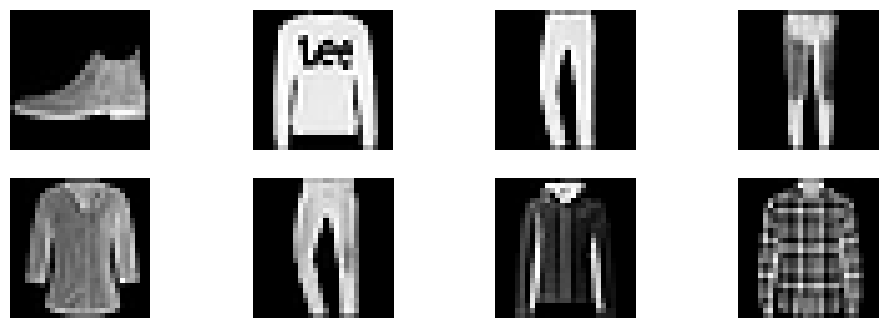

In [5]:
# Visualize some examples from the dataset

import matplotlib.pyplot as plt

def show_samples(dataset, num_samples=4, indices=None):
    plt.figure(figsize=(12, 4))

    if indices is None: indices = range(num_samples)
    for idx, i in enumerate(indices):
        image, _ = dataset[i]
        image = image.detach().cpu().numpy()
        if image.shape[0] == 1 or image.shape[0] == 3:
            image = image.transpose(1, 2, 0)
        plt.subplot(2, 4, idx + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

show_samples(fmnist_test, num_samples=8)

In [6]:
# Sanity check: verify that the correct model was loaded. 
# Accuracy should be 0.9.

from tml2425_xai.xai_utils import model_accuracy

fmnist_accuracy = model_accuracy(lenet, fmnist_test)
assert fmnist_accuracy == 0.9
print(f'Accuracy on the test set: {fmnist_accuracy:.3f}')

Accuracy on the test set: 0.900


Everything works. Great! Next, it's your turn.

## 1.1 Designing the feature attribution evaluation function (10 pts)

First, you will write Python code for evaluating the correctness of a feature attribution explanation with a remove-and-classify approach. In our case, each "feature" is a pixel location. An "explanation" ranks the pixel locations in decreasing order of their importance towards the model's predictions. Then, in order to evaluate the explanation, we remove the pixels in the sequence that the explanation ranks them, and look at the drop in the model's performance. This is what we mean when we say "remove-and-classify". 

After you have written your function for evaluating explanations, you will test it on a dummy explanation (a centred 2D Gaussian over the input image). 

Since removing a feature at a time is slow, we instead remove 100 features in each removal step. 

**Interpretation**: If removing the most important pixels (according to the explanation) causes the steepest drop in the model's performances, the explanation can be deemed as a good one. 

Let's visualize an attribution map to make sure we understand what we are doing.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def show_attribution_overlay(image, attribution_map, alpha=0.5):
    """
    Displays an image with an attribution map overlay.
    
    Parameters:
    - image: The original image as a 2D numpy array or PyTorch tensor.
    - attribution_map: The attribution map as a 2D numpy array or PyTorch tensor, same size as image.
    - alpha: Transparency level for the overlay. (0 = fully transparent, 1 = fully opaque)
    """
    # Convert image and attribution_map to numpy arrays if they are tensors
    if isinstance(image, torch.Tensor):
        image = image.squeeze().cpu().numpy()
        if image.shape[0] == 1 or image.shape[0] == 3:
            image = image.transpose(1, 2, 0)
    if isinstance(attribution_map, torch.Tensor):
        attribution_map = attribution_map.squeeze().cpu().numpy()
    
    # Display the image
    plt.imshow(image, cmap='gray')
    
    # Overlay the attribution map with a color map
    plt.imshow(attribution_map, cmap='jet', alpha=alpha)
    plt.colorbar(label="Attribution Intensity")
    
    # Remove axis and display
    plt.axis('off')
    plt.show()

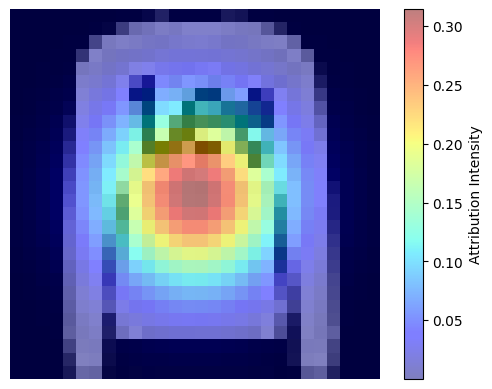

In [8]:
from tml2425_xai.xai_utils import centered_gaussian

idx = 1
gaussian_explanations = torch.zeros((len(fmnist_test), 28, 28))
for i in range(len(fmnist_test)):
    gaussian_explanations[i] = torch.tensor(centered_gaussian(28, 28))
show_attribution_overlay(fmnist_test.data[idx], gaussian_explanations[idx])

**Your turn! Fill in the remove-and-classify function below to evaluate how well the dummy gaussian maps explain the model predictions.**

**Hint:** Try to vectorize your code as much as possible. The slowest possible implementation of this function will take 25 minutes to run on the CUB dataset, while a decently fast one will finish in under a minute. Enough said! :)

In [9]:
# TODO: 10 points

from sklearn.metrics import auc
import torch
from tqdm import tqdm

# This is a tip, you don't have to split up the code into two functions.
# Having them separate makes your code more readable.
def sort_explanations_by_importance(explanations):
    """For each feature map in the explanations list, returns the indices
    that would sort the pixels according to the attribution. Most important
    feature is assigned index 0 and so on.

    :param explanations: list of feature attribution maps
    :returns: list of explanation ranks
    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    total_num_features = explanations[0].numel()
    sorted_inds = torch.argsort(explanations.reshape(explanations.shape[0], total_num_features), dim=1, descending=True)
    ranks = torch.argsort(sorted_inds, dim=1)
    return (ranks.reshape (explanations.shape))
    #### >>>> END OF YOUR SOLUTION <<<<

def remove_and_classify(model, dataset, explanations, k=100):
    """Main remove-and-classify function. Iteratively removes the top k features
    (k, k*2, k*3 until none are left) from all instances in the dataset and
    measures model performance.
    Returns the list of model performances after each removal step.
    :param model: Model to explain
    :param dataset: Image data
    :param explanations: list of explanations corresponding to the dataset.
    :param k: number of features to remove at once, initialized at 100
    :returns: list of model accuracy at removal of k features.
    """

    # input check
    assert len(dataset) == len(explanations) # one explanation per sample
    assert dataset.data.shape[-2:] == explanations[0].shape # each explanation is essentially a pixel importance map
    total_num_features = explanations[0].numel()

    sorted_attribution_ranks = sort_explanations_by_importance(explanations)
    performances = []

    # Unifying processing across two datasets (you will see why later).
    data_shape = dataset[0][0].shape # should be the same of an image
    if len(data_shape) == 2: # fmnist data - grayscale
        width, height = data_shape
        data_iterable = dataset.data
        # Access the fmnist data as data_iterable[index][row, column]
    elif len(data_shape) == 3: # cub data
        channels, width, height = data_shape
        data_iterable = dataset
        # Access the cub data as data_iterable[index][0][channel, row, column]
        # We advise you to implement feature removal in-place. This is not
        # good coding practice, but otherwise you might run out of RAM.

    #### >>>> PUT YOUR SOLUTION HERE <<<<
    num_feat_remove = k
    while num_feat_remove < total_num_features:
        print('Features left:', total_num_features-num_feat_remove)
        if len(data_shape) == 3:
            id_to_display = 43 # Display thisimage id for visualization
            plt.figure()
            plt.imshow(data_iterable[id_to_display][0].permute(1, 2, 0).cpu(), cmap='gray')
            plt.title('Sample {}'.format(id_to_display))
            for idx in range(len(data_iterable)):
                image = data_iterable[idx][0]
                ranks = sorted_attribution_ranks[idx]
                mask = (ranks < num_feat_remove)
                image[:, mask] = 0

        elif len(data_shape) == 2:
            plt.figure()
            plt.imshow(data_iterable[0, :, :].cpu(), cmap='gray')
            data_iterable[sorted_attribution_ranks < num_feat_remove] = 0

        performance = model_accuracy(model, dataset)
        print('Accuracy:', performance)
        performances.append(performance)
        num_feat_remove += k
    #### >>>> END OF YOUR SOLUTION <<<<

    return performances

Run your evaluation code on the test set with the dummy explanations and get the removal performances.
This takes about 1-3 minutes, depending on the GPU you were assigned.

In [10]:
# the remove-and-classify function performs changes in-place, 
# so we load the dataset again 
# in order to make the operations in this cell idempotent
fmnist_test = datasets.FashionMNIST(
    root='./data_FashionMNIST',
    train=False,
    download=True,
    transform=transform
)

k = 100
gaussian_explanations.shape
removal_performances = remove_and_classify(lenet, fmnist_test, gaussian_explanations, k)
removal_performances.insert(0, fmnist_accuracy) # in place, adding the original accuracy in front for AUC

Features left: 684
Accuracy: 0.8567
Features left: 584
Accuracy: 0.827
Features left: 484
Accuracy: 0.7361
Features left: 384
Accuracy: 0.6267
Features left: 284
Accuracy: 0.435
Features left: 184
Accuracy: 0.1531
Features left: 84
Accuracy: 0.131


Next, we plot the model performance as features are removed. We also put a quantifiable number to our evaluation. The lower the RAC score, the better we deem our explanation to be.

The remove and classify score is  0.659


Text(0.5, 0, 'Feature removal step (k=100)')

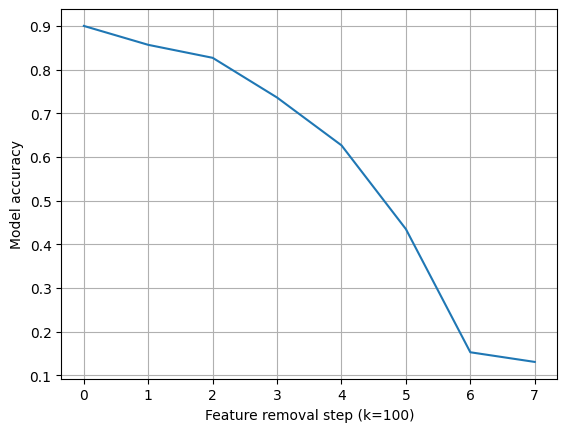

In [11]:
# To get the remove-and-classify score, plot the removal performances for analysis
# also get the AUC of the plot 
import matplotlib.pyplot as plt
rac_score = auc(range(len(removal_performances)), removal_performances)
rac_score_norm = rac_score / auc(range(len(removal_performances)), [fmnist_accuracy]*len(removal_performances))
print(f"The remove and classify score is {rac_score_norm: .3f}")

plt.plot(removal_performances)
plt.grid()
plt.ylabel('Model accuracy')
plt.xlabel('Feature removal step (k=100)')

In [12]:
# Clearing memory in preparation for the next part
%reset_selective -f "\b\
(?!remove_and_classify\b)\
(?!sort_explanations_by_importance\b)\
(?!show_samples\b)\
(?!show_attribution_overlay\b)\
(?!plt\b)\
(?!auc\b)\
(?!rac_score\b)\
w+"


## 1.2 Putting your evaluation function to use

So your evaluation function works. Great job! Now, the centered Gaussian was really a very naive explanation. Can we do better than that? Let's see: we will implement two other methods and find out whether they make a difference.

For this part, we will use a different dataset (CUB) and a different model (ResNet50). As CUB is not a standard PyTorch dataset, we added a bit of functionality to it for our experiments. Loading the dataset takes a bit (roughly 3 min).

In [13]:
import torch
from torchvision import transforms

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [14]:
# prepare the dataset

from tml2425_xai.resnet50 import resnet50
from tml2425_xai.xai_utils import load_cub_test, model_accuracy, centered_gaussian

cub_test = load_cub_test()
num_classes = 200 # 200 Bird species in CUB dataset

100%|██████████| 1150585339/1150585339 [01:27<00:00, 13170931.93it/s]


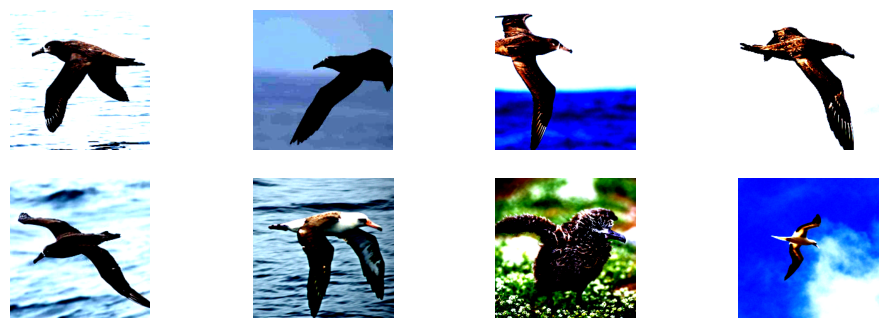

In [15]:
show_samples(cub_test, 8)

**Important:** As mentioned during the lecture, there is an architectural change to the classic ResNet50 in the last layers in the provided model. Usually, a ResNet ends with a global average pooling layer before a dense layer, followed by a softmax. This is equivalent to changing the last layers to a 1x1 convolutional layer, global average pooling followed by softmax. With this architecture change, it is simpler to extract CAM.

In [16]:
resnet = resnet50(dataset_name='CUB',
                    pretrained=False,
                    num_classes=num_classes,
                    large_feature_map=False,
                    use_bn=True)
ckpt = torch.load('tml2425_xai_models/cam_cub_checkpoint.pth.tar')
resnet.load_state_dict(ckpt["state_dict"])
resnet.to(device)
resnet.eval()

/tmp/ipykernel_30/4176620627.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('tml2425_xai_models/cam_cub_checkpoint.pth.tar')


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
# Sanity check for CUB

cub_accuracy = model_accuracy(resnet, cub_test)
assert cub_accuracy == 0.798
print(f'Accuracy on the test set: {cub_accuracy:.3f}')

Accuracy on the test set: 0.798


In [18]:
# This will come in handy.

from tqdm import tqdm

def get_explanations(explanation_function, model, dataset):
    """Computes the explanations for the whole dataset specified in dataset

    :param explanation_function: python function that takes arguments model, dataset, idx
    :param model: model to be explained
    :param dataset: dataset to be used to explain the model
    """
    explanations = []
    for idx in tqdm(range(len(dataset))):
        e = explanation_function(model, dataset, idx)
        assert e.shape == dataset[0][0].shape[-2:]
        explanations.append(e)
    return torch.stack(explanations, dim=0)

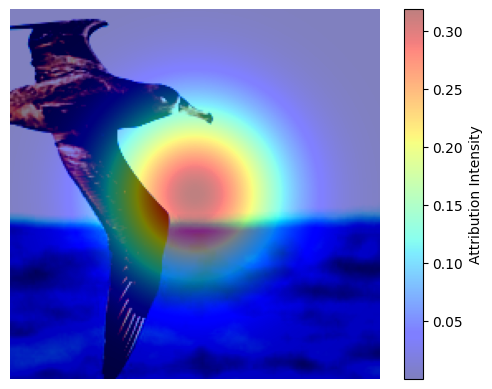

In [19]:
## Example. Visualizing the gaussian baseline as an attribution explanation overlay.
show_attribution_overlay(cub_test.data[2], centered_gaussian(224, 224))

## 1.2.0  Evaluate Gaussian map baseline

Similar to what we did in §1.1, except that now we use the CUB dataset instead.

In [20]:
# Evaluation of gaussian map baseline
# First, get the explanations
import time

cub_test = load_cub_test()

start = time.time()
baseline_explanations = torch.stack([torch.Tensor(centered_gaussian(224,224))]*len(cub_test), dim=0)
print('Time taken to compute baseline explanations: ', time.time() - start)

Files already downloaded and verified


In [21]:
# then remove-and-classify
import time
start = time.time()
cub_test = load_cub_test()
k = 10000
baseline_removal_performances = remove_and_classify(resnet, cub_test, baseline_explanations, k)
baseline_removal_performances.insert(0, cub_accuracy)
print(time.time() - start)

Files already downloaded and verified
Features left: 40176
Accuracy: 0.35
Features left: 30176
Accuracy: 0.056
Features left: 20176
Accuracy: 0.024
Features left: 10176
Accuracy: 0.014
Features left: 176
Accuracy: 0.007
45.58239388465881


The remove and classify score is  0.212


Text(0.5, 0, 'Feature removal step (k=10000)')

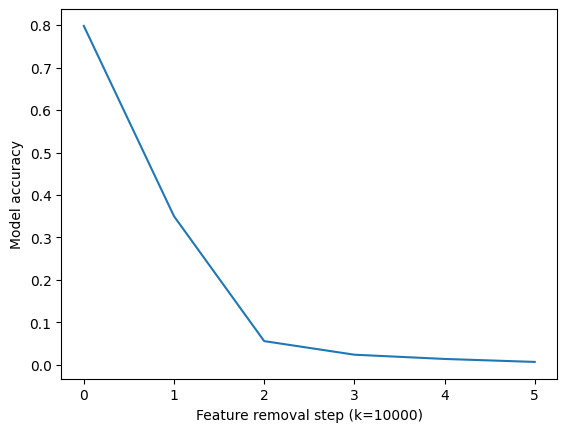

In [22]:
from sklearn.metrics import auc
# Inspect the results
rac_score = auc(range(len(baseline_removal_performances)), baseline_removal_performances)
rac_score_norm = rac_score / auc(range(len(baseline_removal_performances)), [cub_accuracy]*len(baseline_removal_performances))
print(f"The remove and classify score is {rac_score_norm: .3f}")
import matplotlib.pyplot as plt
plt.plot(baseline_removal_performances)
plt.ylabel('Model accuracy')
plt.xlabel('Feature removal step (k=10000)')

## 1.2.1 Implement input gradient explanations (10 pts)

First, you will implement the vanilla gradient explanation method as a baseline to compare to (10 points). Write a function to get the saliency map from [Simonyan et al. (2013)](http://arxiv.org/abs/1312.6034) as a local explanation.

In [23]:
# TODO: 10 points

def saliency(model, dataset, sample_idx):
    """Computes the saliency map of the predicted class as a feature attribution explanation.
    From Simonyan et al. (2013)

    :param model: predictive model
    :param dataset: dataset containing the instance to be explained
    :param sample_idx: ID of the instance to be explained
    :returns: saliency map of shape (224, 224) in case of CUB
    """
    # Tip: Look at the assumptions for RGB images in the paper.
    image, _ = dataset[sample_idx]
    image = image.to(device)
    image = image.unsqueeze(0) # to get the batch size dimension
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    model.eval()
    image.requires_grad_()
    output = model(image)
    predicted_class = output.argmax(dim=1).item()
    model.zero_grad()
    output[0, predicted_class].backward()
    saliency_map = image.grad.abs().squeeze()
    if saliency_map.dim() == 3:
        saliency_map, _ = saliency_map.max(dim=0)
    #### >>>> END OF YOUR SOLUTION <<<<
    return saliency_map.cpu()

torch.Size([224, 224])


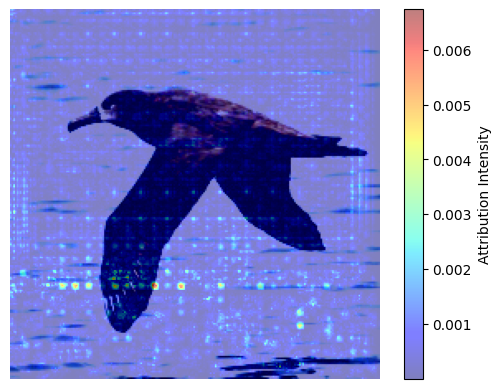

In [24]:
# Evaluation of saliency
cub_test = load_cub_test()

saliency_attribution = saliency(resnet, cub_test, 0)
print(saliency_attribution.shape)

show_attribution_overlay(cub_test.data[0], saliency_attribution)

In [25]:
import time
# Evaluation of saliency
cub_test = load_cub_test()

# First, get the explanations
start = time.time()
saliency_explanations = get_explanations(saliency, resnet, cub_test)
print('Time taken to compute saliency explanations: ', time.time() - start)

Files already downloaded and verified


100%|██████████| 1000/1000 [00:24<00:00, 40.78it/s]


Files already downloaded and verified
Features left: 40176
Accuracy: 0.285
Features left: 30176
Accuracy: 0.081
Features left: 20176
Accuracy: 0.027
Features left: 10176
Accuracy: 0.016
Features left: 176
Accuracy: 0.006
The remove and classify score is  0.203


Text(0.5, 0, 'Feature removal step (k=10000)')

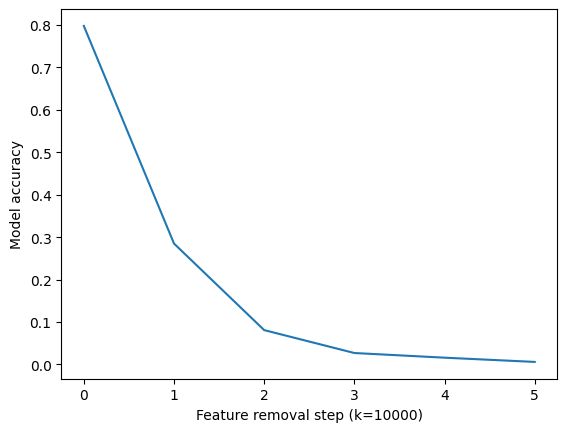

In [26]:
# then remove-and-classify
cub_test = load_cub_test()

k = 10000
saliency_removal_performances = remove_and_classify(resnet, cub_test, saliency_explanations, k)
saliency_removal_performances.insert(0, cub_accuracy)

# Inspect the results
rac_score = auc(range(len(saliency_removal_performances)), saliency_removal_performances)
rac_score_norm = rac_score / auc(range(len(saliency_removal_performances)), [cub_accuracy]*len(saliency_removal_performances))
print(f"The remove and classify score is {rac_score_norm: .3f}")

plt.figure()
plt.plot(saliency_removal_performances)
plt.ylabel('Model accuracy')
plt.xlabel('Feature removal step (k=10000)')
plt.show()

## 1.2.2 Implement CAM (10 pts)

Next, you will implement the feature attribution explanation method [CAM by Zhou et al. (2016)](http://ieeexplore.ieee.org/document/7780688/).



In [134]:
# TODO: 10 points

def class_activation_map(model, dataset, sample_idx):
    """Gets the class activation map of the predicted class as a feature attribution explanation from the last convolutional layer of adapted ResNet model.
    Originally from Zhou et al. (2016)

    :param model: Adapted ResNet model in with 1x1 convolution
    :param dataset: dataset containing the instance to be explained
    :param sample_idx: ID of the instance to be explained
    :returns: CAM of shape (224, 224) in case of CUB
    """
    # Tip: use the hook method to extract the activations of particular layers
    # Hook method below from https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    image, _ = dataset[sample_idx]
    image = image.to(device)
    image = image.unsqueeze(0) # to get the batch size dimension
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    model.eval()
    model.conv_last.register_forward_hook(get_activation('conv_last'))
    output = model(image)
    pred_cls = torch.argmax(output.squeeze()).item()
    cam = activation['conv_last'][:, pred_cls, :, :].unsqueeze(0)
    _, _, H, W = image.shape
    cam_resized = torch.nn.functional.interpolate(cam, size=(H, W), mode='bilinear', align_corners=False)
    return cam_resized.squeeze()
    #### >>>> END OF YOUR SOLUTION <<<<

In [135]:
cub_test = load_cub_test()

cam = class_activation_map(resnet, cub_test, 12)

show_attribution_overlay(cub_test.data[12], cam)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

RuntimeError: einsum(): the number of subscripts in the equation (1) does not match the number of dimensions (3) for operand 0 and no ellipsis was given

In [ ]:
# Evaluation of CAM
import matplotlib.pyplot as plt
import time

# First, get the explanations
cub_test = load_cub_test()
start = time.time()
cam_explanations = get_explanations(class_activation_map, resnet, cub_test)
print('Time taken to compute CAM explanations: ', time.time() - start)

In [ ]:
# then remove-and-classify.
cub_test = load_cub_test()
k = 10000
cam_removal_performances = remove_and_classify(resnet, cub_test, cam_explanations, k)
cam_removal_performances.insert(0, cub_accuracy)

In [ ]:
# Inspect the results
from sklearn.metrics import auc

rac_score = auc(range(len(cam_removal_performances)), cam_removal_performances)
rac_score_norm = rac_score / auc(range(len(cam_removal_performances)), [cub_accuracy]*len(cam_removal_performances))
print(f"The remove and classify score is {rac_score_norm: .3f}")

plt.plot(cam_removal_performances)
plt.ylabel('Model accuracy')
plt.xlabel('Feature removal step (k=10000)')

## 1.3 Discussion (20 pts)

**PLEASE VIEW THE MARKDOWN CODE INSTEAD OF THE DISPLAY MODE. SOME NUMBERS AND TEXT ARE DISPLAYED INCORRECTLY IN THE DISPLAY MODE.**

This kind of exercise aims to train you in scientific argumentation. In well-written research papers, you will often see results reported in roughly the same format as we ask you to adopt below.

**Question**: Introduce the motivation for the experiment(s) in §1. Clearly state the research question, and the experimental setting. (4 points)

**TODO your answer:**

In recent years, CNN-based models have achieved state-of-the-art performance on Computer Vision tasks like image classification. However, it is essential to build greater trust in these models by demystifying the computations performed by them. To this end, many explanation techniques have been developed to identify the crucial parts of images that influence the model predictions. These techniques achieve this by assigning a feature attribution score to each individual pixel in the image.

In our work, we propose a framework to evaluate the effectiveness of the feature attribution scores computed by these explanation techniques. In particular, we attempt to evaluate whether these attribution scores truly capture the important pixels in the image that contribute significantly to the model prediction. For a good explainer, we would expect the classification performance to drop substantially if we mask the most important pixels given by this explainer. To address this question, we adopt a "remove-and-reclassify" approach wherein we mask a number of important pixels as given by the attribution scores, and then observe the model performance on the resulting image. Our experimental setup enables us to evaluate the quality of various explainers by comparing the performance drops on removing the important pixels given by each explainer. Our key contributions are as follows
- A "remove-and-reclassify" framework to evaluate the various CNN explainers in the existing literature
- A novel "remove-and-classify" score that encapsulates the quality of feature attributions given by an explainer and facilitates easy comparison between different explainers
- A systematic comparison of explainers like Saliency Map and CAM with a baseline Gaussian feature attribution map


**Question**: Describe the results *factually* (i.e., do not draw any conclusions yet -- just share what you observe and find interesting). Use a combination of visual inspection and quantitative analysis. Make sure to point to specific data points in plots, tables etc. (4 points)

**TODO your answer:**

In our experiments, we evaluate different explainers for a ResNet architecture trained to classify images from the CUB dataset. We considered the following explainers in our evaluation
- Gaussian baseline- Assigns a higher score to pixels near the center of the image
- Input Gradient Explanations- Computed using the gradient of the output layer w.r.t the input image
- Class Activation Maps (CAM)- Activation maps of the last convolutional layer.

With each explainer, we compute the feature attribution score for each pixel and rank the pixels in decreasing order of feature attribution scores. The pixels that are deemed more important by the explainer come first and the ones deemed lees important come later in the order. We iteratively remove the pixels in multiple steps: in the first step, we remove the 10,000 most important pixels, followed by removing the next 10,000 pixels in the second step, and so on, replacing them with black pixels at each step.

Note that the original images have 224 x 224 = 50,176 pixels and we remove 10,000 pixels in each step. We report the classification accuracy at each removal step. We also summarize these accuracies with an RAC (remove-and-classify) score, which is the area below the accuracy vs feature removal curves plotted in sections 1.1 and 1.2.
**IMPORTANT NOTE: Some of the numbers in the table are displayed incorrectly in Markdown. Please view the Markdown code (instead of display mode) or refer to the results from 1.1 and 1.2 for the correct numbers**

|                         | **Baseline** | **Saliency Map** | **CAM**  |
|-------------------------|--------------|------------------|----------|
| **Original images**     | 0.798        | 0.798            | 0.798    |
| **10k removed**         | 0.408        | 0.071            | 0.090    |
| **20k removed**         | 0.159        | 0.032            | 0.032    |
| **30k removed**         | 0.040        | 0.026            | 0.016    |
| **40k removed**         | 0.011        | 0.009            | 0.006    |
| **50k removed**         | 0.005        | 0.004            | 0.005    |
| **RAC score**           | 0.256        | 0.135            | 0.137    |

<br>The results from this table can be visualized by plotting the "Accuracy vs Removal step" curves for all three explainers on the same graph. Please see the graph in the output of the next code cell. <br>
The original accuracy of the model (before removing any pixels from the images) was 0.798. On removing the first 10k pixels, the accuracy dropped to 0.408 for the baseline explainer. On the other hand, we observed a very sharp drop in the accuracy for Saliency Map (0.798 to 0.071) and CAM (0.090). As we remove more pixels in further steps, we observe that the gap between the baseline and the other two explainers narrows down. The large initial drop for Saliency Map and CAM leads to a lower RAC score for these classifiers (0.135 and 0.137 respectively) as compared to the baseline (0.256).

**Question**: Draw conclusion(s). Was the research question (that you stated above) answered? Why or why not? (4 points)

**TODO your answer:**

These results provide a thorough comparison between the performance of the baseline, Saliency Map and CAM explainers. If the feature attribution scores given by an explainer truly reflect the pixels that are important for the model's prediction, one would expect a large drop in the accuracy on removing pixels with high attribution scores. This is becuase the model would find it difficult to predict the correct class if we remove the most important pixels that contribute to the model's prediction.

In the first and second removal steps, we observe a large drop for Saliency Map and CAM, whereas the drop is much smaller for the baseline explainer. Thus, we conclude that Saliency Map and CAM assign high attribution scores to the pixels that significantly influence the model's prediction. One the other hand, the attribution scores given by the baseline explainer may not indicate the important pixels that the model focuses on. Hence, Saliency Map and CAM provide more faithful explanations that give a better insight into the underlying model.

**Question**: What does the evaluation say about CAM and its comparison with baseline approaches? (4 points)

**TODO your answer:**

The table and plots clearly indicate that CAM and Saliency Map are better explainers compared to the baseline. On comparing CAM with Saliency Map, we observe that the RAC score and the accuracies at various steps are quite similar. So, the results in the table may not be sufficient to perform a good comparison between the feature attributions of CAM and Saliency Map. However, we could use some other criteria to compare the two.

The running time is a practically useful criteria for compare Saliency Maps with CAM. In our experiments, we observed that Saliency Map took 22 seconds to compute the explanations for 1000 images, whereas CAM only required 11 seconds. This is because Saliency Map performs a full backward pass to compute the gradient w.r.t. the input image, but CAM only requires the activations of the last convolutional layer. Since Saliency Map and CAM give a similar quality of explanations as indicated by the RAC score, we might prefer CAM for its lower computational cost.

Another comparison criteria could be the visualized attribution maps generated by Saliency Map and CAM. (Please see the displayed images in 1.1 and 1.2) Since CAM gives attributions for the last convolutional layer which are then projected to the original image, it only indicates broad regions (e.g. the bird's head) that are important for the prediction. On the other hand, Saliency Map provides attribution maps at a much finer resolution that show more specific details (e.g. bird's eyes and beak) that the model focuses on. For analyzing and debugging a model, it could be helpful to use Saliency Map since it provides more fine-grained explanations compared to CAM.


**Question**: What could be the limitations of the remove-and-classify approach used here? Does it make sense to, for instance, weigh different parts of the AUC differently? (4 points)

**TODO your answer:**

In the remove-and-classify curve, it would be useful to focus more on the pixels that are ranked higher by an explainer. This is because the higher ranked pixels provide more information about the parts that the model focuses on. Hence, it would be useful to assign a higher weight to the initial removal steps as compared to the later ones. For example, we could compare the Saliency Map with CAM using a weighted RAC score. Since Saliency Map gives a larger drop in accuracy compared to CAM in the first step, we would get a better RAC score for Saliency Map.  

Also, it might be useful to consider feature attribution maps at varying resolutions such as 2 x 2 regions, 10 x 10 regions etc instead of considering them at the pixel-level only. This might provide a more fair comparison between Saliency MAP and CAM because we could then observe the effect of removing pixels in regions of different sizes.

In [ ]:
# Plot performances of all 3 explainers to compare them
plt.figure()
plt.plot(baseline_removal_performances, label='Baseline')
plt.plot(saliency_removal_performances, label='Saliency')
plt.plot(cam_removal_performances, label='CAM')
plt.ylabel('Model accuracy')
plt.xlabel('Feature removal step (k=10000)')
plt.legend()
plt.show()

In [ ]:
# Remove all defined variables from memory for the next exercise
# from https://www.skillsugar.com/how-to-delete-variables-functions-from-memory-in-python

for element in dir():
    if element[0:2] != "__":
        del globals()[element]

del element

# 2 Explaining predictions with Training Data Attribution (TDA)

In this part of the exercise sheet we will fine-tune a tiny language model on a sentiment-analysis task, and analyze its predictions using Influence Functions. It is a classic Training Data Attribution method, first introduced in the context of deep neural networks in [Koh & Liang 2017](https://arxiv.org/abs/1703.04730).

*WARNING: Influence functions are computationally intensive. We will retrain models many times in this part of the exercise sheet. Start early.*

*Recommended start: 28/11/2024*

## 2.0 Fine-tune a tiny langauge model for text classification (no points to earn here)

In this exercise, we fine-tune a pre-trained [DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert) language model to do sentiment analysis on the [Rotten tomatoes dataset](https://huggingface.co/datasets/rotten_tomatoes). This dataset contains positive and negative movie reviews and the task is to classify them. Each example is just one sentence.

This model is not state-of-the-art by a long shot, but hopefully by the end of this exercise sheet you will understand why we decided to go for a tiny model and a tiny dataset.
This exercise closely follows the [Huggingface task guide for text classification](https://huggingface.co/docs/transformers/tasks/sequence_classification). Don't hesitate to consult this guide and HF docs in general if something is not clear.

You don't need to code anything new yet. But make sure you understand what this code does.
This will be useful to you for 2 reasons:
 - You will use the functions defined here in the following exercises.
 - Fine-tuning a pre-trained language model is easy, fun and teaches you a useful skill as well as the basics of using the Huggingface transformers library.


In [1]:
# You will usually not find these libraries in your typical Colab / Kaggle environments
!pip install transformers[torch] datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.4 MB/s eta 0:00:00


In [2]:
# Import the required libraries
from collections import defaultdict
import datasets as ds
import evaluate as ev
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import transformers as tf
from tqdm import tqdm
from typing import Dict, List, Union, Optional, Tuple, Iterator, Any

In [3]:
# Constants used later in the code
MODEL_NAME = "distilbert-base-uncased"
DATASET_NAME = "rotten_tomatoes"
WEIGHT_DECAY = 0.01
NUM_LABELS = None # Filled automatically

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [4]:
# Fixing random seeds for reproducibility
def apply_random_seed(random_seed):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

apply_random_seed(2024)

In [5]:
def load_train_and_test_data():
    # Load the dataset from huggingface hub
    dataset_dict = ds.load_dataset(DATASET_NAME)
    assert "train" in dataset_dict.keys(), "Dataset must contain 'train' split."
    assert "test" in dataset_dict.keys(), "Dataset must contain 'test' split."
    assert "text" in dataset_dict["train"].features.keys(), "Dataset must contain a 'text' column. Preprocess it if needed."
    assert "label" in dataset_dict["train"].features.keys(), "Dataset must contain a 'label' column. Preprocess it if needed."

    global NUM_LABELS
    NUM_LABELS = dataset_dict["train"].features["label"].num_classes
    
    # Preprocess the dataset
    
    # 1. Take a subset of the dataset. 
    # https://huggingface.co/docs/datasets/process#shard
    dataset_dict["train"] = dataset_dict["train"].shard(num_shards=8, index=3)
    dataset_dict["test"] = dataset_dict["test"].shard(num_shards=2, index=1)

    # 2. Tokenize the dataset. This creates the input_ids and attention_mask columns.
    # Consult https://huggingface.co/learn/nlp-course/chapter2/4?fw=pt for an overview of tokenization.
    tokenizer = tf.AutoTokenizer.from_pretrained(MODEL_NAME)

    def preprocess_function(example):
        return tokenizer(example["text"], truncation=True)

    dataset_dict = dataset_dict.map(preprocess_function, batched=True)

    # 3. Convert the dataset to PyTorch tensors.
    # Not usually necessary, but our Influence Function computation needs it.
    dataset_dict["train"].set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    dataset_dict["test"].set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    return dataset_dict["train"], dataset_dict["test"]


In [6]:
def train_default_model_on_dataset(dataset, eval_dataset=None):
    # Suppress warnings and info logs
    tf.logging.set_verbosity_error()

    # Provide readable names for the labels
    id2label = {i: label for i, label in enumerate(dataset.features["label"].names)}
    label2id = {label: i for i, label in id2label.items()}
    # Download the model and the corresponding tokenizer
    model = tf.AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id
    ).to(DEVICE)
    tokenizer = tf.AutoTokenizer.from_pretrained(MODEL_NAME)

    # Data collator pads the inputs to the maximum length in the batch.
    # This is needed because the sentences in the dataset have different lengths.
    data_collator = tf.DataCollatorWithPadding(tokenizer=tokenizer)

    # We use the accuracy metric to evaluate the model, since the task is classification.
    accuracy = ev.load("accuracy")
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        return accuracy.compute(predictions=predictions, references=labels)

    training_args = tf.TrainingArguments(
        output_dir="outdir",
        learning_rate=4e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=2,
        weight_decay=WEIGHT_DECAY,
        save_strategy="no",
        report_to="none",
        disable_tqdm=False if eval_dataset else True,
        log_level="error",
        evaluation_strategy="epoch" if eval_dataset else "no",
    )
    trainer = tf.Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    # A hack to stop the trainer from printing the results after each epoch.
    # Relevant because we will retrain the model a lot in this notebook.
    trainer.remove_callback(tf.trainer_callback.PrinterCallback)

    # Run the training.
    train_res = trainer.train()
    # Set verbosity back to warning
    tf.logging.set_verbosity_warning()

    return trainer.model

In [7]:
train_data, test_data = load_train_and_test_data()

README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/533 [00:00<?, ? examples/s]

In [8]:
print(f"Number of train examples: {len(train_data)}")
print(f"Number of test examples: {len(test_data)}")
example = train_data[0]
print(example)

Number of train examples: 1066
Number of test examples: 533
{'label': tensor(1), 'input_ids': tensor([  101,  2065,  2017,  2823,  2066,  2000,  2175,  2000,  1996,  5691,
         2000,  2031,  4569,  1010,  2001, 28518,  2003,  1037,  2204,  2173,
         2000,  2707,  1012,   102]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}


We preprocessed the text inputs to be readable for the language model that we will now train.

To actually read the text in this example we would have to decode it with the tokenizer.

Note that [CLS] at the start and [SEP] at the end were not part of the data. These are special tokens that are added by the BERT tokenizer.

In [9]:
tokenizer = tf.AutoTokenizer.from_pretrained(MODEL_NAME)
print(tokenizer.decode(example["input_ids"]))

[CLS] if you sometimes like to go to the movies to have fun, wasabi is a good place to start. [SEP]


In [10]:
trained_model = train_default_model_on_dataset(train_data, eval_dataset=test_data)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.442156,0.804878
2,No log,0.416900,0.818011


The model achieves around 80% accuracy on the test set. Now let's try to use [the huggingface pipelines](https://huggingface.co/docs/transformers/main_classes/pipelines) to classify some text.

In [11]:
text = "If you sometimes go to the movies to have fun, this movie is not a good place to start."

classifier = tf.pipeline("sentiment-analysis", model=trained_model, tokenizer=tokenizer, device=DEVICE)

classifier(text)

[{'label': 'neg', 'score': 0.8833626508712769}]

## 2.1 Evaluate influence functions by retraining (10 points)

Influence functions are designed to be an approximation of the difference in loss after leave-one-out retraining. However, the theory only proves that this works for strictly convex models. For our task, we have to resort to empirical evaluation.

In this exercise, we will evaluate our implementation of Influence Functions.
We will do this by comparing the confidence of the model in the correct answer before and after retraining without influential samples.
What you should expect: When you remove helpful samples, the probability of correct answer should decrease. This is because in our definition of the influence of the training sample $z_j$ on the test sample $z$:
$IF(z_j, z) \approx L(z, \theta_{\setminus j}) - L(z, \theta)$, so positive influence means removing a given training sample would increase the
loss on the test sample.

Removing harmful samples should increase the probability of correct answer. Removing random data should only show a small downward trend.

To achieve this, we will:
 - Pick a small set of test points
 - For each test point we will:
    - Compute the model's confidence in correct answer
    - Compute the influences of the training samples
    - Retrain the model while removing 10, 20, 30 and 50 % of influential samples of each kind
        - Filter the datasets and use the function ```train_default_model_on_dataset``` from §2.0
    - Compute the model's confidence in correct answer after retraining
 - Average the results over test points
 - Plot the results
    - Plotting is done for you. To see how it looks like and the needed format, we provide```dummy_results_dict``` in the plotting code.
     Change the plotting code to use the actual ```results_dict``` when you're done with the computation.
 - Make sure that you measure the time needed to execute the full evaluation and record it. You will report it in the Discussion part of this exercise.

We also provide a dummy influence function, on which you can test your evaluation function. Later, in §2.2, we will write real influence functions.

First, let's see what the result of the influence function computation should look like using a dummy variable, `dummy_results_dict`.

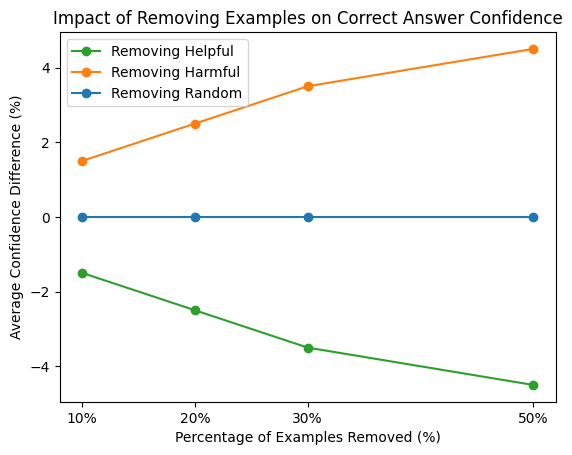

In [12]:
removed_amounts = [0.1, 0.2, 0.3, 0.5]

def plot_influence_function_evaluation(results_dict):
    fig, ax = plt.subplots()
    colors = {"Helpful": 'tab:green', "Harmful": 'tab:orange',"Random": 'tab:blue'}
    
    for key, value in results_dict.items():
        means = [np.mean(value[amount]) for amount in removed_amounts]
        ax.plot(removed_amounts, means, '-o', label=f"Removing {key}", color=colors[key])
    
    ax.set_xlabel('Percentage of Examples Removed (%)')
    ax.set_ylabel('Average Confidence Difference (%)')
    ax.set_title('Impact of Removing Examples on Correct Answer Confidence')
    ax.set_xticks(removed_amounts)
    x_tick_labels = [f"{int(x*100)}%" for x in removed_amounts]
    ax.set_xticklabels(x_tick_labels)
    ax.legend()
    
    plt.show()
 
"""results_dict is a dictionary with the keys 
    - "Helpful" (describing the influence of removing the most positively influential training examples), 
    - "Harmful" (describing the influence of removing the most negatively influential training examples, 
    - "Random" (describing the influence of removing samples in random order).

    Each value in itself is a dict. Let's take the value corresponding to "Helpful", for example.
    Each subkey here is a floating point number denoting the amount of (in this case, the most influential) training samples removed.
    And then, the value corresponding to each subkey is a list with as many elements as the nuumber of test samples (2 in this case).
    So, 0.1: [-1, -2] denotes that removing the top 10% helpful samples resulted in confidence decreases of 1% and 2% for the given test samples, respectively.
    Similarly, 0.3: [3, 4] under "Harmful" denotes that removing the top 30% most harmful samples resulted in confidence increases of 3% and 4% for the given test samples, respectively.
    When plotting, we average over the influences on all test samples.
"""
dummy_results_dict = {
    "Helpful": {0.1: [-1, -2], 0.2: [-2, -3], 0.3: [-3, -4], 0.5: [-4, -5 ]},
    "Harmful": {0.1: [1, 2], 0.2: [2, 3], 0.3: [3, 4], 0.5: [4, 5]},
    "Random": {0.1: [0, 0], 0.2: [0, 0], 0.3: [0, 0], 0.5: [0, 0]},
}
plot_influence_function_evaluation(dummy_results_dict)

In [13]:
import numpy as np

def dummy_influence_function(model, tokenizer, test_inputs, train_data, knn_indices=None):
    # Generate random influence scores for each training example
    influence_scores = {i: np.random.uniform(-1, 1) for i in range(len(train_data))}
    # Return the influence scores and a placeholder for any additional info (e.g., confidence scores)
    return influence_scores, None

In [14]:
# TODO: 3 points

def get_confidence_of_correct_answer(model, example):
    """Get the probability of the correct answer in example under the model.
    Recall that each `example` is a dict with keys "input_ids", "labels", 
    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    input_ids = example["input_ids"]
    labels = example["labels"]

    with torch.no_grad():
        logits = model(input_ids).logits
    
    #print (logits.shape)
    probabilities = torch.softmax(logits, dim=-1)
    confidence = probabilities[range(len(labels)), labels]
    #### >>>> END OF YOUR SOLUTION <<<<
    return confidence

In [15]:
# TODO: 7 points

def evaluate_by_retraining(
    influence_function,
    train_data,
    training_function,
    test_data,
    model,
    tokenizer,
    use_knn: bool = False,
):

    if use_knn:
        print("Using KNN Speedup.")
        print("Emebedding train data...")
        embedded_train_data = embed_training_dataset(model, tokenizer, train_data)

    print("Training on original dataset")
    trained_model = training_function(train_data)

    results_dict = {
        "Helpful": defaultdict(list),
        "Harmful": defaultdict(list),
        "Random": defaultdict(list),
    }
    
    test_example_indices = [x for x in range(10, 13)]

    # Measure the time
    start_ts = time.time()

    for i, idx in enumerate(test_example_indices):
        print(f"Running test example {i} / {len(test_example_indices)}")
        test_example = {
            "input_ids": test_data["input_ids"][idx].view(1, -1).to(DEVICE),
            "attention_mask": test_data["attention_mask"][idx].view(1, -1).to(DEVICE),
            "labels" : test_data["label"][idx].view(1, -1).to(DEVICE),
        }

        if use_knn:
            print(f"Searching for the k nearest neighbors")
            knn_indices = get_knn_indices(model, embedded_train_data, test_example, k=300)
            
        # Compute confidence of correct answer before retraining
        c_pre = get_confidence_of_correct_answer(trained_model, test_example)
    
        #### >>>> PUT YOUR SOLUTION HERE <<<<
        c_pre = get_confidence_of_correct_answer(trained_model, test_example)
        influences, _ = influence_function(model, tokenizer, test_example, train_data)
        sorted_indices = sorted(influences, key=influences.get)
        
        helpful_indices = sorted_indices[-int(0.5 * len(sorted_indices)):]
        harmful_indices = sorted_indices[:int(0.5 * len(sorted_indices))]
        random_indices = np.random.choice(len(train_data), len(harmful_indices), replace=False)

        removed_amounts = [0.1, 0.2, 0.3, 0.5]  # Percentage of data to remove

        for amount in removed_amounts:
            num_to_remove = int(amount * len(train_data))

            helpful_removed = train_data.select([i for i in range(len(train_data)) if i not in helpful_indices[:num_to_remove]])
            harmful_removed = train_data.select([i for i in range(len(train_data)) if i not in harmful_indices[:num_to_remove]])
            random_removed = train_data.select([i for i in range(len(train_data)) if i not in random_indices[:num_to_remove]])
            #print (helpful_removed)
            
            for key, filtered_data in zip(["Helpful", "Harmful", "Random"],[helpful_removed, harmful_removed, random_removed],):
                retrained_model = training_function(filtered_data)
                c_post = get_confidence_of_correct_answer(retrained_model, test_example)
                results_dict[key][amount].append((c_post - c_pre).item())
        #### >>>> END OF YOUR SOLUTION <<<<

    print("\nResults:\n")
    for key in results_dict:
        for amount in removed_amounts:
            print(f"{key}: Removed {amount} examples. Average confidence difference: {np.mean(results_dict[key][amount]):.2f}% (std: {np.std(results_dict[key][amount]):.2f})")
    print(f"Time elapsed: {time.time() - start_ts:.2f}s")

    return results_dict

In [16]:
import warnings
warnings.filterwarnings("ignore")

random_influence_results_dict = evaluate_by_retraining(
    dummy_influence_function,
    train_data,
    train_default_model_on_dataset,
    test_data,
    trained_model,
    tokenizer,
)

Training on original dataset
Running test example 0 / 3
Running test example 1 / 3
Running test example 2 / 3

Results:

Helpful: Removed 0.1 examples. Average confidence difference: -0.02% (std: 0.11)
Helpful: Removed 0.2 examples. Average confidence difference: -0.13% (std: 0.23)
Helpful: Removed 0.3 examples. Average confidence difference: -0.11% (std: 0.14)
Helpful: Removed 0.5 examples. Average confidence difference: -0.18% (std: 0.19)
Harmful: Removed 0.1 examples. Average confidence difference: 0.06% (std: 0.07)
Harmful: Removed 0.2 examples. Average confidence difference: -0.12% (std: 0.09)
Harmful: Removed 0.3 examples. Average confidence difference: -0.03% (std: 0.11)
Harmful: Removed 0.5 examples. Average confidence difference: -0.18% (std: 0.23)
Random: Removed 0.1 examples. Average confidence difference: -0.01% (std: 0.20)
Random: Removed 0.2 examples. Average confidence difference: -0.14% (std: 0.26)
Random: Removed 0.3 examples. Average confidence difference: -0.03% (std

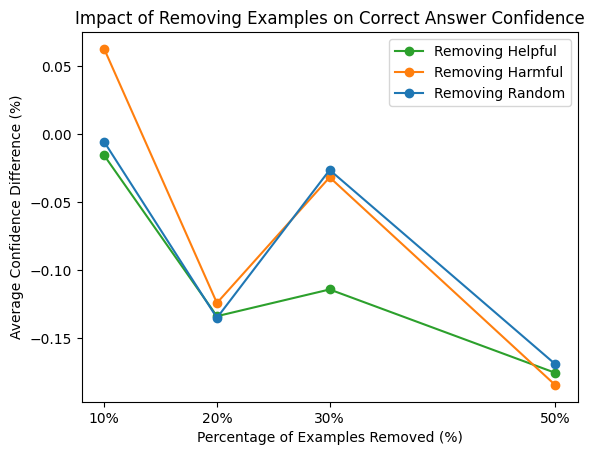

In [17]:
# Try plotting the results obtained above
plot_influence_function_evaluation(random_influence_results_dict)

As you can see, there is no real trend to see here. Remember that we used a random influence function with the purpose of testing your evaluation function. Next, we will write real influence functions, and you will be able to see some patterns emerge.

## 2.2 Implementing an influence function

Let's jump right into it.

## 2.2.1 Influence Function: LISSA (10 pts)

This small exercise aims to simulate real-world research experience. In machine learning, we often want to reproduce results from papers that we read. 
We do that to check the validity of those results, use them as baselines for comparisons, or just build on top of them. 
The ability to navigate a research paper codebase is thus crucial for your success as machine learning users and developers.

Below you will find the code for computing Influence Functions, adapted (mostly simplified) from the [FastIF repository](https://github.com/salesforce/fast-influence-functions).
This is the repository for the [FastIF paper](https://aclanthology.org/2021.emnlp-main.808.pdf).
Before reading the code or the paper you might find it helpful to watch the [short video from the author](https://aclanthology.org/2021.emnlp-main.808.mp4).

After the code there is a small example for using it on the model that we have just trained in Section 2.0.

Your goal here is to read the code and answer the Questions below.

In [18]:
def get_loss(model: torch.nn.Module, inputs: Dict[str, torch.Tensor]) -> float:
    for k, v in inputs.items():
        inputs[k] = v.to(DEVICE)
    outputs = model(**inputs)
    loss = outputs.loss

    # In PyTorch, weight-decay loss and gradients are calculated in optimizers
    # rather in nn.Module, so we have to manually specify this for the loss here.
    no_decay = ["bias", "LayerNorm.weight"]
    weight_decay_loss = torch.cat([
        param.square().view(-1)
        for name, param in model.named_parameters()
        if not any(nd in name for nd in no_decay)
    ]).sum() * WEIGHT_DECAY
    loss = loss + weight_decay_loss
    return loss

In [19]:
def compute_gradients(
        model: torch.nn.Module, inputs: Dict[str, torch.Tensor], params_filter: Optional[List[str]],
) -> List[torch.FloatTensor]:

    if params_filter is None:
        params_filter = []

    model.zero_grad()
    loss = get_loss(model=model, inputs=inputs)

    filtered_params = [
        param for name, param in model.named_parameters() if name not in params_filter
    ]
    return torch.autograd.grad(outputs=loss, inputs=filtered_params, create_graph=True)

In [20]:
def compute_hessian_vector_products(
        model: torch.nn.Module,
        inputs: Dict[str, torch.Tensor],
        vectors: torch.FloatTensor,
        params_filter: Optional[List[str]],
) -> List[torch.FloatTensor]:

    if params_filter is None:
        params_filter = []

    model.zero_grad()
    loss = get_loss(model=model, inputs=inputs)

    filtered_params = [
        param for name, param in model.named_parameters() if name not in params_filter
    ]
    grad_tuple = torch.autograd.grad(
        outputs=loss,
        inputs=filtered_params,
        create_graph=True
    )

    model.zero_grad()
    grad_grad_tuple = torch.autograd.grad(
        outputs=grad_tuple,
        inputs=filtered_params,
        grad_outputs=vectors,
        only_inputs=True
    )

    return grad_grad_tuple

In [21]:
def compute_s_test(
        model: torch.nn.Module,
        test_inputs: Dict[str, torch.Tensor],
        train_data_loader: torch.utils.data.DataLoader,
        params_filter: Optional[List[str]],
        damp: float,
        scale: float,
) -> List[torch.FloatTensor]:

    v = compute_gradients(model=model, inputs=test_inputs, params_filter=params_filter)
    # Technically, it's hv^-1
    last_estimate = list(v).copy()
    for i, inputs in enumerate(train_data_loader):
        this_estimate = compute_hessian_vector_products(
            model=model,
            vectors=last_estimate,
            inputs=inputs,
            params_filter=params_filter,
        )
        # Recursively caclulate h_estimate
        # https://github.com/dedeswim/pytorch_influence_functions/blob/master/pytorch_influence_functions/influence_functions/hvp_grad.py#L118
        with torch.no_grad():
            new_estimate = [
                a + (1 - damp) * b - c / scale
                for a, b, c in zip(v, last_estimate, this_estimate)
            ]

        last_estimate = new_estimate

    # Reference: https://github.com/kohpangwei/influence-release/blob/master/influence/genericNeuralNet.py#L475
    # Do this for each iteration of estimation # Since we use one estimation, we put this at the end
    inverse_hvp = [X / scale for X in last_estimate]
    return inverse_hvp


In [22]:
def compute_influences(
        model: torch.nn.Module,
        tokenizer: tf.PreTrainedTokenizer,
        test_inputs: Dict[str, torch.Tensor],
        train_data: ds.Dataset,
        knn_indices: Optional[set] = None,
        params_filter: Optional[List[str]] = None,
        s_test_damp: float = 3e-5,
        s_test_scale: float = 1e4,
        s_test_iterations: int = 1,
        precomputed_s_test: Optional[List[torch.FloatTensor]] = None,
) -> Tuple[Dict[int, float], Dict[int, Dict], List[torch.FloatTensor]]:

    data_collator = tf.DataCollatorWithPadding(tokenizer=tokenizer)

    # Create data loaders from the huggingface dataset
    instance_train_data_loader = DataLoader(
        train_data, batch_size=1, sampler=SequentialSampler(train_data), collate_fn=data_collator
    )
    batch_train_data_loader = DataLoader(
        train_data, batch_size=32, sampler=RandomSampler(train_data), collate_fn=data_collator
    )

    if s_test_iterations < 1: raise ValueError("`s_test_iterations` must >= 1")

    if precomputed_s_test is not None:
        s_test = precomputed_s_test
    else:
        s_test = None
        for _ in range(s_test_iterations):
            iter_s_test = compute_s_test(
                model=model,
                test_inputs=test_inputs,
                train_data_loader=batch_train_data_loader,
                params_filter=params_filter,
                damp=s_test_damp,
                scale=s_test_scale,
            )

            # On first iteration use the computed value, on further iterations sum the values across runs
            s_test = iter_s_test if s_test is None else [a + b for a, b in zip(s_test, iter_s_test)]

        # Do the averaging
        s_test = [a / s_test_iterations for a in s_test]

    influences = {}
    for index, train_inputs in enumerate(tqdm(instance_train_data_loader)):
        if knn_indices is not None and index not in knn_indices: continue

        grad_z = compute_gradients(model=model, inputs=train_inputs, params_filter=params_filter)
        with torch.no_grad():
            influence = [torch.sum(x * y) for x, y in zip(grad_z, s_test)]

        influences[index] = sum(influence).item()

    return influences, s_test

In [23]:
# Example for using the influence functions
text = "I greatly enjoyed this movie and will recommend it to everyone!"
test_example = tokenizer(text, return_tensors="pt")
test_example['labels'] = torch.tensor([1])
test_example.to(DEVICE)

# Compute influences
influences, _ = compute_influences(
    model=trained_model, tokenizer=tokenizer, test_inputs=test_example, train_data=train_data
)

# Take the 5 most influential examples
top_5_idc = sorted(influences, key=influences.get, reverse=True)[:5]
top_5_t_i_l = [
    (
        tokenizer.decode(train_data[idx]["input_ids"], skip_special_tokens=True),
        influences[idx],
        train_data[idx]["label"]
     )
    for idx in top_5_idc
]
_ = [print(f"Label: {l}, Influence: {i:.2f}, Text: {t}") for (t, i, l) in top_5_t_i_l]

100%|██████████| 1066/1066 [00:30<00:00, 34.66it/s]

Label: 1, Influence: 0.31, Text: this one is strictly a lightweight escapist film.
Label: 1, Influence: 0.31, Text: an effectively creepy, fear - inducing ( not fear - reducing ) film from japanese director hideo nakata, who takes the superstitious curse on chain letters and actually applies it.
Label: 1, Influence: 0.31, Text: whenever you think you ' ve figured out late marriage, it throws you for a loop.
Label: 1, Influence: 0.30, Text: falls neatly into the category of good stupid fun.
Label: 1, Influence: 0.29, Text: ... an agreeable time - wasting device - - but george pal ' s low - tech 1960 version still rules the epochs.


In [24]:
# Let's evaluate this influence function
lissa_results_dict = evaluate_by_retraining(
    compute_influences,
    train_data,
    train_default_model_on_dataset,
    test_data,
    trained_model,
    tokenizer,
)

Training on original dataset
Running test example 0 / 3


100%|██████████| 1066/1066 [00:30<00:00, 34.79it/s]


Running test example 1 / 3


100%|██████████| 1066/1066 [00:30<00:00, 34.74it/s]


Running test example 2 / 3


100%|██████████| 1066/1066 [00:30<00:00, 34.65it/s]



Results:

Helpful: Removed 0.1 examples. Average confidence difference: -0.07% (std: 0.03)
Helpful: Removed 0.2 examples. Average confidence difference: -0.16% (std: 0.04)
Helpful: Removed 0.3 examples. Average confidence difference: -0.33% (std: 0.22)
Helpful: Removed 0.5 examples. Average confidence difference: -0.65% (std: 0.19)
Harmful: Removed 0.1 examples. Average confidence difference: 0.16% (std: 0.10)
Harmful: Removed 0.2 examples. Average confidence difference: 0.18% (std: 0.15)
Harmful: Removed 0.3 examples. Average confidence difference: 0.27% (std: 0.18)
Harmful: Removed 0.5 examples. Average confidence difference: 0.33% (std: 0.19)
Random: Removed 0.1 examples. Average confidence difference: 0.06% (std: 0.11)
Random: Removed 0.2 examples. Average confidence difference: -0.06% (std: 0.06)
Random: Removed 0.3 examples. Average confidence difference: -0.09% (std: 0.16)
Random: Removed 0.5 examples. Average confidence difference: -0.09% (std: 0.06)
Time elapsed: 360.13s


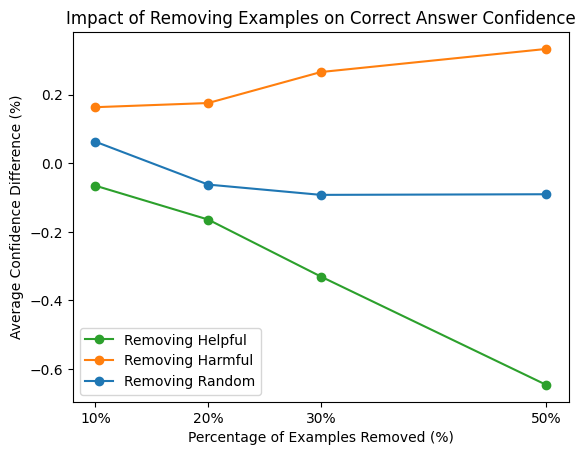

In [25]:
plot_influence_function_evaluation(lissa_results_dict)

### Questions

**Question 1** (1 point)

Which equation from the [FastIF paper](https://aclanthology.org/2021.emnlp-main.808.pdf) does the function ```compute_s_test``` represent? A number is enough.

**TODO your answer:**
Equation 4

**Question 2** (2.5 points)

Why does the function ```compute_s_test``` need a ```train_data_loader``` parameter if it computes something for the test sample, as indicated by its name?

**TODO your answer:**
The function ```compute_s_test``` needs a ```train_data_loader``` because it approximates the inverse hessian vector product which contains information reagrding the curvature of the loss function. This in turn is affected by the training data.  ```train_data_loader``` then provides these training data items in small mini batches.

**Question 3** (4 points)

Section 3.3 of the paper describes the LISSA approximation to compute inverse hessian vector product (IHVP) in three steps: **Step 1**, **Step 2**, and **Step 3**.
Locate each step in the code and cite it in your answer.

*Example*:

**Step 1**
```
the_code = cited_in_markdown()
```
**TODO your answer:**

**Step 1** initialize inverse HVP estimation
```
v = compute_gradients(model=model, inputs=test_inputs, params_filter=params_filter)
last_estimate = list(v).copy()
```

**Step 2** recursively compute inverse HVP estimation
```
for i, inputs in enumerate(train_data_loader):
        this_estimate = compute_hessian_vector_products(
            model=model,
            vectors=last_estimate,
            inputs=inputs,
            params_filter=params_filter,
        )
        # Recursively caclulate h_estimate
        # https://github.com/dedeswim/pytorch_influence_functions/blob/master/pytorch_influence_functions/influence_functions/hvp_grad.py#L118
        with torch.no_grad():
            new_estimate = [
                a + (1 - damp) * b - c / scale
                for a, b, c in zip(v, last_estimate, this_estimate)
            ]

        last_estimate = new_estimate
```

**Step 3** repeat and average the inverse HVP estimations
```
# Reference: https://github.com/kohpangwei/influence-release/blob/master/influence/genericNeuralNet.py#L475
# Do this for each iteration of estimation # Since we use one estimation, we put this at the end
inverse_hvp = [X / scale for X in last_estimate]
return inverse_hvp
```

**Question 4** (2.5 points)

If you wanted to speed-up the computation by only considering the gradient to some subset of the NN weights, which parameter
of the function ```compute_influences``` would you use and how?
A short description in words is enough, no need to implement it.

**TODO your answer:**
The params_filter parameter should be a list of strings corresponding to the names of the parameters (e.g.,subset of weights) in the model that we want to include in the computation of gradients. This would speed up computation if we specified a subset of NN weights.


## 2.2.2 Speed up the computations using kNN (10 points)

Your goal in this exercise is to speed up the search for influential samples by only running the search on a subset of
the training set that is expected to be influential, as described [in section 3.2 of the paper](https://aclanthology.org/2021.emnlp-main.808.pdf).

We will do this by first running a k-nearest-neighbors search over the full dataset. Then we will compute the influences of the found neighbors by providing the ```knn_indices``` parameter to the ```compute_influences``` function. *Note that IHVP is still computed using the full training set.* This two-step procedure is expected to be faster while still finding the influential samples.

**Evaluation**

After implementing this part, please plot the results (code provided below).
You should see evaluation results comparable with full-search, but faster.
Record the time needed to run the evaluation and report the time comparison with the full search.

**How to search for neighbors**

To implement the nearest neighbor search we need to measure similarity between a test sample $x$ and a train
sample $x_j$. This is often done in machine learning by embedding both in a vector space and computing the distance
between the 2 vectors. A typical way to construct such embeddings is to take the last layer activations of our neural network. This is a common trick for deep metric learning: the assumption is that this way we obtain a good representation of our sample in a lower-dimensional space that preserves the semantics.

In our task, both $x$ and $x_j$ are sequences. Moreover, they have varying lengths, and a transformer model generates an embedding for each of the tokens at every layer.

The solution that is often adopted when one needs to embed an entire sentence with a BERT-type model is to take
the last layer embedding of the ```[CLS]``` token. You have already encountered this token in part 2.0 of this exercise.
If everything works correctly, it should be the first token of the input. If you want to check for it, you can find the
ID of this token by ```tokenizer.cls_token_id```.

In [26]:
# Let's look at the trained model again
trained_model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [27]:
# To give you hints for solving the upcoming questions
out = trained_model(**test_example, output_hidden_states=True)
print(len(out.hidden_states))
print(out.hidden_states[-1].shape)

7
torch.Size([1, 14, 768])


In [28]:
# TODO: 2 points

def embed_one_example(model, example):
    """Computes the last layer embedding of the [CLS] token for one example."""
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    with torch.no_grad():
        out = model(**example, output_hidden_states=True)
    last_hidden_state = out.hidden_states[-1]
    #print (last_hidden_state)
    cls_embedding = last_hidden_state[:, 0, :]
    return cls_embedding
    #### >>>> END OF YOUR SOLUTION <<<<


In [29]:
# TODO: 2 points

def embed_training_dataset(model, tokenizer, train_dataset):
    """Create a list of embeddings for the training dataset.
    To be used for the kNN search.
    """
    data_collator = tf.DataCollatorWithPadding(tokenizer=tokenizer)
    train_dataloader = DataLoader(
        train_data, batch_size=1, sampler=SequentialSampler(train_data), collate_fn=data_collator
    )
    embeddings = []
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    model.eval()

    with torch.no_grad():
        for batch in train_dataloader:
            batch = {key: val.to(DEVICE) for key, val in batch.items() if key in ["input_ids", "attention_mask", "labels"]}
            embedding = embed_one_example(model, batch)
            embeddings.append(embedding.squeeze(0).cpu().numpy()) 
    #print (embeddings)
    #### >>>> END OF YOUR SOLUTION <<<<
    return embeddings

In [30]:
# TODO: 6 points

def get_knn_indices(model, embedded_train_data, test_input, k=100):
    """Returns the set of indices of the k nearest neighbors of test_input in the training dataset."""
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    test_embedding = embed_one_example(model, test_input).cpu().numpy()
    distances = np.linalg.norm(embedded_train_data - test_embedding, axis=1)
    knn_indices = np.argsort(distances)[:k]
    #### >>>> END OF YOUR SOLUTION <<<<
    return knn_indices

In [ ]:
# Let's evaluate the kNN speedup

lissa_knn_results_dict = evaluate_by_retraining(
    compute_influences,
    train_data,
    train_default_model_on_dataset,
    test_data,
    trained_model,
    tokenizer,
    use_knn=True,
)

Using KNN Speedup.
Emebedding train data...
Training on original dataset
Running test example 0 / 3
Searching for the k nearest neighbors


100%|██████████| 1066/1066 [00:31<00:00, 33.42it/s]


In [ ]:
# Plot the results
plot_influence_function_evaluation(lissa_knn_results_dict)

## 2.3 Discussion (20 pts)

Similarly to §1.3, here we ask you to answer some questions about the experiments in this section.

**Question 1**: How big was the speed-up that you observed? Explain your observations. (5 points)

The speed up is not really significant using knn's in our case. It comes to around 1 second. We are not really sure why this is the case. Even with respect to performance, it seems that it is only slightly better.

**Question 1**:  Does this type of evaluation make sense to you? What are its pros and cons? (5 points)

Training data evaluation can be crucial in various situations. It can help to filter out corrupted data points, help with debugging the model, and improve explainability and trust which leads to better ethical considerations. However, some cons can be that influence functions are expensive to calculate and then the question arises, whether the pros outweigh this con. Further, it is sensitive to model used and over optimizing might lead to overfitting scenario.

**Question 1**: In this type of soundness evaluation we use random removal as a baseline. What could some other reasonable baselines be? (5 points)

Some other reasonable baselines can be 
1. removing from least confident data itself
2. uniform removal from each class
3. removal from examples that the model makes a mistake with


**Question 1**: Try to come up with 2 practical applications of Training Data Attribution not mentioned in the lecture and explain why they are useful. (Citing existing work not cited in the lecture is welcome.) (5 points)

Two practical applications would be:
1. Personalizing educational AI systems : can be used to personalize recommendations by identifying which past student interactions had the biggest impact on predictions for learning progress. This allows tailored feedback and fair assessment because we know which data points are outliers and how they affect the model. (understanding how training data impacts user recommendations is key to improving transparency (Piech et al., 2015). TA methods can play an important role in enhancing these systems.)


2. Debugging AI models in medicine : can be used to identify mislabeled or noisy data in dataset. Preventing this kind of mislabeling can be potentially life saving and makes the model more accurate. Retraining or curating these datasets may be expensive and in such cases training data attribution might help to prioritize certain data points. Further, understanding which data points have the most impact also makes the model more transparent. (Koh and Liang (2017) used influence functions to trace model predictions back to influential training points.) 

*(No points, feedback question)* What is your personal opinion on TDA methods? Do you see an application for them in your own projects? If yes - how, and if not - why? How would you compare them with feature-based attribution methods?

# 3 (Bonus) Short Paper Review (10 points)

In this bonus task, your task is to write a short review for **one** of the following papers:
- [Analyzing Chain-of-Thought Prompting in Large Language Models via
Gradient-based Feature Attributions](https://arxiv.org/abs/2307.13339).
- [Driving with LLMs: Fusing Object-Level Vector Modality for Explainable Autonomous Driving](https://arxiv.org/pdf/2310.01957.pdf)
- [On Gradient-like Explanation under a Black-box Setting: When Black-box Explanations Become as Good as White-box](https://arxiv.org/pdf/2308.09381.pdf)

Below are a few questions to consider in a review as inspiration (Slightly adapted from [ICML'22 reviewer guide](https://drive.google.com/file/d/15hPTA64h31ShaoybLWeU3moZan7zVbr_/view))
- A concise summary of the paper
    - What problem is addressed in the paper?
    - Why does the problem matter?
    - What is the key to the solution? What is the main contribution?
    - Do the experiments sufficiently support the claims?
- A clear statement of strengths and weaknesses
    - What are the key contributions and why do they matter?
    - What aspects of the paper most need improvement?
- A comprehensive check of potential fundamental flaws in the paper
    - Are the assumptions and theories (mathematically) sound?
    - Are the experiments scientifically sound and valid?
    - Is the problem addressed trivial?

When reviewing, adress the paper from the angle of Trustworthy AI, specifically focusing on the topic of Explainability.

# Driving with LLMs: Fusing Object-Level Vector Modality for Explainable Autonomous Driving

### 1 Concise paper summary

The paper introduces a multimodal framework to integrate object-level vectorized numeric modalities with pre-trained LLMs for autonomous driving tasks.For example, they employ vector captions such as "A moving car; Angle in degrees: 1.19; Distance: 9.98m".It aims to improve decision-making explainability by using textual reasoning capabilities that LLMs are already capable of. The authors propose a two-stage process: first, a pretraining phase that aligns vector embeddings with language representations; second, fine-tuning that enables the system to answer driving-related questions and predict actions. The paper also presents the Driving QA dataset, consisting of 160k question-answer pairs based on 10k driving scenarios, and introduces a metric for evaluating the interpretability of driving actions.

#### 1.1 What problem is addressed in the paper?

The paper targets the black-box nature of traditional autonomous driving systems. For instance, most systems won't be transparent about the driving decisions made, like why the vehicle slowed down when it did, making debugging difficult. Existing architectures like Perceiver-BC, perform worse in detailed reasoning tasks such as predicting normalized acceleration (MAE of 0.18 for Perceiver-BC vs. 0.066 for the pre-trained LLM-Driver).

#### 1.2 Why does this problem matter?
   
Explainability in autonomous driving ensures safety and trust, as vehicles that can clearly articulate why they made certain decisions not only comply with regulatory standards but also help passengers (and all other stakeholders) feel more confident in their operation. This is especially important in safety-critical scenarios, where understanding the logic behind a vehicle’s actions could make the difference between preventing or contributing to an accident.

If we focus, for example on Fig. 4 from the paper showing LLM-Driver’s reasoning: it slows down because "a pedestrian is crossing from the left, and the traffic light ahead is red.", we can see that this explanation is absent in other systems. Systems like Perceiver-BC, while accurate in simple tasks like traffic light detection (90%), fall short in reasoning-heavy tasks. This is why explainable approach is necessary, especially in driving tasks where where edge cases and OOD scenarios are so common. Hence this paper aims to solve this very important problem (which is also highlighted in Section6).


#### 1.3 What is the key to the solution and main contribution?
   
* The paper introduces a framework that integrates object-level vectorized numeric modalities (ex., vehicle positions, pedestrian data, traffic lights) with pre-trained LLMs using a two-stage pretraining and fine-tuning process. This includes:
    - A Vector Encoder to transform numeric vectors (which are inputs like pedestrian positions and car speeds) into a latent space.
    - A Vector Former for embedding these latent vectors into a format decodable by LLMs.
    - A LoRA-adapted LLaMA-7b LLM to process the multimodal data and output interpretable language-based reasoning.

* The authors curated a (reusable) dataset of 160k question-answer (QA) pairs generated with a custom RL agent based on 10k uniquely simulated driving scenarios mapped to a captioning model (lanGen) which extracts text from the vectorized data. For example, each scenario includes control commands and Q&A like "How are you going to drive in this situation?" along with model predictions like "Steering straight with brake at 80%."

* A two-stage training process that ensures effective multimodal learning:
    - Pretraining aligns the object-level numeric data with language embeddings using pseudo-captioning.
    - Fine-tuning incorporates the Driving QA dataset to train the model on reasoning and decision-making tasks.


* Driving QA tasks score the model at 8.39/10 (GPT-graded for interpretability) versus 7.48/10 for non-pretrained models, validating the solution.

* The paper benchmarks the proposed model against a Perceiver-BC baseline, which uses a transformer based policy module instead of an LLM. Results show that the LLM-based model significantly outperforms the baseline in both perception and reasoning tasks ((Elat: 0.014 → 0.01437),(Elon: 0.094 → 0.066) and increased reasoning capabilities-> 9.1% improvement in GPT QA grading scores after pretraining (discussed in 1.4)) .


#### 1.4 Do the experiments sufficiently support claims?

The following claims are supported by experiments in this paper:
1. Pretraining improves perception and action prediction:
    - Car Detection (Ecar): MAE improved from 0.101 (without pretraining) to 0.066 (with pretraining).
    - Token Prediction Loss (Ltoken): dropped significantly from 0.644 to 0.502
    -  Pedestrian Detection (Eped): improved a lot, with MAE decreasing from 1.668 to 0.313 after pretraining along with traffic lights conditions compared to the baseline--> better situational awareness.
      
2. Pretraining improves relevant and explainable answers in Driving QA:
    - Human Grading: Scores improved from 6.63 (without pretraining) to 7.71 (with pretraining).
    - GPT Grading: Scores rose from 7.48 to 8.39-> more alignment between the model output and our expectation.

3. LLM-Driver performs better than Perceiver-BC in prediction tasks:

    - Elat: Error reduced to 0.014 with LLM pretraining, compared to 0.111 for Perceiver-BC.
    - Elon: MAE dropped from 0.180 (Perceiver-BC) to 0.066 (pretrained LLM-Driver).
    - Pedestrian detection accuracy: LLM-Driver outperformed Perceiver-BC, with MAE dropping from 0.684 to 0.313.
  
3. Object-level vector modality improves multi-modal integration for driving tasks:

   - AccTL: Pretrained LLM-driver: 71.8 % vsPerceiver-BC: 90% (but lacks interpretability)
   - DTL: Pretrained LLM-driver: 6.624m error vs Non-pretrained: 7.475m error
   - Simpler models like Perceiver-BC perform better in basic regression tasks like traffic light detection as it is designed for direct perception tasks and doesn't require the reasoning that LLMs are optimized for.

Some observations definitely do need further clarification:
* Lack of closed-loop evaluations (model should operate continuously in a simulated or real-world environment) limits the ability to generalize the results to real-world scenarios, as acknowledged in Sec 5. The experiments rely entirely on synthetic data that may not capture all nuances of real-world conditions. GPT-based grading

* Although Driving QA results show improvements in reasoning and answer quality, depending on GPT-based grading introduces potential biases as it can sometimes overrate semantically close but incorrect answers. Hand-labeling results for a larger subset of QA pairs might give us a stronger validation.

### Clear statement of strengths and weaknesses

Strengths of the paper:

1. The approach is the first to fuse vectorized object-level data with LLMs (= multimodal integration) for autonomous driving. Usually, we see papers that either rely solely on vision-based models (needing extensive labeled data) or treat numeric data in isolation.
2. By converting vector data into language-based outputs, the system can explain decisions in human-readable text (ex. system justifies braking by citing pedestrian presence or red traffic lights).
3. The Driving QA dataset includes 160k question-answer pairs derived from simulated scenarios, providing a benchmark for evaluating reasoning and explainability in autonomous driving. The dataset is structured using an RL agent and GPT-generated labels. All models, datasets, and benchmarks are also open source!
4. Experiments show measurable improvements due to pretraining (see answer 1.4 point 1).


Weaknesses:

1. Open-loop experiments fail to capture the dynamics of real-world interaction-- they can mask cascading errors that emerge in closed-loop systems (current decision affects future state). A slight miscalculation in acceleration/steering angle could lead to compounding mistakes over time in a real driving scenario.
2. The system is trained and tested entirely on a simulator, where driving scenarios are procedurally generated. While this provides a controlled environment, it cannot fully capture the complexity of real-world conditions as discussed previously.
3. Over-reliance on GPT-based grading risks inflating performance metrics (model might give a plausible explanation that aligns with training data but fails to reflect the actual driving context).
4. The model employs LLaMA-7b adapted with LoRA for fine-tuning. This is very tough to deploy in real time scenarios! If the model's latency prevents it from responding quickly to dynamic situations (e.g., sudden braking for a jaywalker), it could compromise safety.
5. While the system provides textual justifications, it does not offer other forms of interpretability, like saliency maps or visual overlays that can better help monitor and debug decisions made by the system.

#### Why do the key contributions (discussed in 1.3) matter?

- Most existing systems rely heavily on vision-based models, which are resource-intensive and less compact.We can reason directly on numeric data while using LLMs' ability to articulate its decisions.
- The Driving QA dataset provides a benchmark for evaluating explainability in driving systems.
-  Pretraining improves the grounding of numeric modalities into the LLM, as evidenced by reductions in token prediction loss and car detection errors (refer to earlier discussed results).
-  Fine-tuning enhances interpretability, enabling the system to explain decisions in a human-readable format, improving trust in automation.
-  Traditional autonomous driving evaluations focus solely on perception and action metrics (e.g., MAE or accuracy) and neglect explainability. Driving QA evaluation score prioritizes explainabilityand enables direct comparisons across models.

#### What aspects of the paper most need improvement?
As we can see from the weaknesses of the paper, some improvements are suggested:

1. We can think to implement this setup in closed-loop simulations, allowing decisions to influence subsequent states. We can use simulators like CARLA to evaluate long-term behavior and safety-critical scenarios. From this we get continuous metrics (much more meaningful) such as cumulative error over time or failure rates during set driving sequences.

2. We may use datasets like nuScenes or Waymo to validate OOD situations in a much more real setting. Further we can also introduce edge cases into the training data.

3. Instead of completely using GPT- 3.5 for grading QA, we can incorporate larger-scale human evaluation of QA responses for critical driving questions.Also, better penalize (ex. assigning negative weights) to incorrect explanations.

4. Latency in decision-making (e.g., braking for a jaywalker) could jeopardize safety when we try to use such a huge model like LLaMA-7b with LoRA. We can explore smaller LLMs (like DistilGPT used here) and optimize architectures for speed without significant loss in performance. Inference can also take time, so we can implement model quantization, pruning, or knowledge distillation techniques. Also, we can use hardware accelerators!

5. The system explains its decisions in text but does not provide visual overlays, saliency maps, or other interpretable features. For this, we can think of integrating something like a Grad-CAM or attention heatmaps to highlight which regions influenced a decision.Develop dashboards or interfaces that combine textual justifications with visual representations (e.g., bounding boxes, trajectory paths).

### Comprehensive Check of Potential Fundamental Flaws in the paper

#### Are the assumptions and theories (mathematically) sound?
Let's go through the key steps in the paper:

1. The paper assumes that object-level numeric vector modalities can be effectively aligned with pre-trained LLMs through structured captions.
For this, they use a MLP to project raw numeric vectors into a latent space. Pretraining objective optimizes for token prediction by minimizing cross-entropy loss on pseudo-language captions. We see that pretraining improves performance quite well, so this is justified.
2. The next important assumption is that using RL agents in a 2D simulator to generate driving scenarios provides sufficiently realistic data. 2D simulation isn't quite close to a real-setting with occlusions for example, but the training reward function (Appendix B.2, Eqn 1) seems to be correctly formulated.
3. We try to see if generating a QA dataset uses cross-entropy loss to train the model to predict accurate answers. Evidence can be seen in the grading difference (explained before) so this is valid as well.
4. They have used pseudo-language captions assuming it provides a decent representation of object-level vectors for training. For this, loss penalizes errors in vector->text mapping. But here, these pseudo-captions might oversimplify real-world vector representations.


#### Are the experiments scientifically sound and valid?

The experiments are scientifically valid, with clear objectives, robust evaluation metrics, and good comparison against Perceiver-BC baseline (ensuring performance differences stem from architectural choices, not model size, as both models have similar trainable parameters (~25 million)). The use of pretraining and RL is well-established. The results show clear improvements, like lesser MAE for pedestrian detection and better QA performance (and other results as we saw above). The approach of using cross-attention for multi-modal data also makes sense mathematically.

#### Is the problem addressed trivial?

Definitely not..  the paper tries to solve a very difficult problem of ensuring that AI can not only predict actions but also explain them to us. This is a critical step toward making autonomous systems more reliable and trustworthy, especially in safety critical scenarios.
